# PCK Parser Demonstration

This notebook demonstrates how to use the `pck_parser` module to extract constants from SPICE PCK kernel files.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pooch

from planets.pck_parser import (
    extract_body_radii,
    parse_multiple_files,
    parse_pck_file,
)


## Retrieve most recent PCK Files

This is hardcoded into the parser, so no need to copy this somewhere.

In [2]:
pck_file = Path(
    pooch.retrieve(
        "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/pck00011.tpc",
        known_hash="sha256:3dff7b1dbeceaa01f25467767d3fa25816051c85d162d1edf04acb310ee28bb1",
    )
)
pck_file_03 = Path(
    pooch.retrieve(
        "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/a_old_versions/pck00003.tpc",
        known_hash="sha256:7f22fb3ebc71d5d75bd2d73a386cdc91db1d742bd9737b1b326f919d7a976064",
    )
)

## Parse a Single PCK File

Let's parse a single PCK file to see what constants are available.

In [3]:
# Parse the first PCK file (if any exist)
print(f"Parsing file: {pck_file.name}")

# Parse the file
constants = parse_pck_file(pck_file)

print(f"Found {len(constants)} constants")

# Show a few example constants
print("\nExample constants:")
for i, (key, data) in enumerate(list(constants.items())[:5]):
    print(f"{key}: {data['value']} (Block {data['block']})")
    if i >= 4:
        break

Parsing file: b5a8070e9cb831ca0b790fe26032ced3-pck00011.tpc
Found 528 constants

Example constants:
BODY10_POLE_RA: [286.13, 0.0, 0.0] (Block 2)
BODY10_POLE_DEC: [63.87, 0.0, 0.0] (Block 2)
BODY10_PM: [84.176, 14.1844, 0.0] (Block 2)
BODY10_LONG_AXIS: [0.0] (Block 2)
BODY199_POLE_RA: [281.0103, -0.0328, 0.0] (Block 3)


## Extract Body Radii

Now let's extract the radii values for all bodies in the PCK file.

In [4]:
if "constants" in locals():
    # Extract radii information
    radii = extract_body_radii(constants)
    print(f"Found radii for {len(radii)} bodies")

    # Create a DataFrame for better display
    radii_data = []
    for body_id, values in radii.items():
        if len(values) >= 3:
            radii_data.append(
                {
                    "Body ID": body_id,
                    "Equatorial Radius 1 (km)": values[0],
                    "Equatorial Radius 2 (km)": values[1],
                    "Polar Radius (km)": values[2],
                }
            )

    # Create DataFrame
    df_radii = pd.DataFrame(radii_data)

    # Sort by body ID
    df_radii = df_radii.sort_values("Body ID")

    # Display the DataFrame
    df_radii.head(10)

Found radii for 95 bodies


## Major Planets

Let's focus on the major planets of our solar system.

In [5]:
# NAIF IDs for major planets
planet_ids = {
    199: "Mercury",
    299: "Venus",
    399: "Earth",
    499: "Mars",
    599: "Jupiter",
    699: "Saturn",
    799: "Uranus",
    899: "Neptune",
    999: "Pluto",
}

if "radii" in locals():
    # Extract data for major planets
    planet_data = []
    for body_id, name in planet_ids.items():
        if body_id in radii and len(radii[body_id]) >= 3:
            values = radii[body_id]
            planet_data.append(
                {
                    "Planet": name,
                    "Body ID": body_id,
                    "Equatorial Radius (km)": values[0],
                    "Polar Radius (km)": values[2],
                    "Flattening": (values[0] - values[2]) / values[0],
                }
            )

    # Create DataFrame
    df_planets = pd.DataFrame(planet_data)

    # Sort by body ID
    df_planets = df_planets.sort_values("Body ID")

    # Display the DataFrame
    df_planets

## Visualize Planet Sizes

Let's create a bar chart to visualize the sizes of the planets.

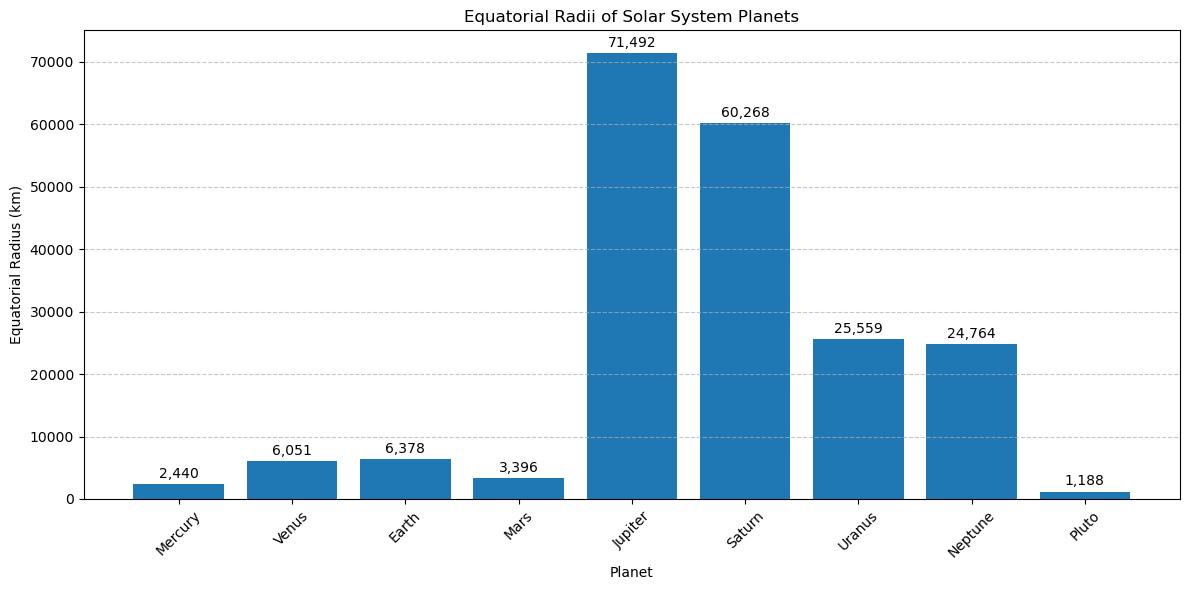

In [6]:
if "df_planets" in locals() and not df_planets.empty:
    # Set up the figure
    plt.figure(figsize=(12, 6))

    # Create bar chart
    bars = plt.bar(df_planets["Planet"], df_planets["Equatorial Radius (km)"])

    # Add labels and title
    plt.xlabel("Planet")
    plt.ylabel("Equatorial Radius (km)")
    plt.title("Equatorial Radii of Solar System Planets")

    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 500,
            f"{int(height):,}",
            ha="center",
            va="bottom",
            rotation=0,
        )

    # Show the plot
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Compare Data Across Different PCK Versions

Let's compare the data across different PCK file versions to see if there are any changes in the values.

In [7]:
pck_files = [pck_file, pck_file_03]

In [8]:
pck_file

PosixPath('/Users/maye/Library/Caches/pooch/b5a8070e9cb831ca0b790fe26032ced3-pck00011.tpc')

In [9]:
pck_file_03

PosixPath('/Users/maye/Library/Caches/pooch/87c5b4ba278028f9202bb23a7b5c88c4-pck00003.tpc')

In [12]:
if len(pck_files) > 1:
    # Parse all PCK files
    all_data = parse_multiple_files(pck_files)

    # Extract radii from each file
    all_radii = {}
    for filename, constants in all_data.items():
        version = Path(filename).stem.split("-")[1]  # Gets filename without extension, then splits
        all_radii[version] = extract_body_radii(constants)

    # Compare Earth's radius across versions
    earth_id = 399
    earth_radii = {}

    for version, radii_dict in all_radii.items():
        if earth_id in radii_dict:
            earth_radii[version] = radii_dict[earth_id]

    # Display the comparison
    print("Earth's radii across different PCK versions:")
    for version, radii in earth_radii.items():
        print(f"{version}: {radii}")
else:
    print("Need multiple PCK files to compare versions.")

Earth's radii across different PCK versions:
pck00011: [6378.1366, 6378.1366, 6356.7519]
pck00003: [6378.14, 6378.14, 6356.75]


## Conclusion

This notebook demonstrated how to use the PCK parser to extract constants from SPICE PCK kernel files. The parser can be used to extract a variety of constants, including radii, gravitational parameters, and orientation data for planetary bodies.

In [13]:
df_planets

,Planet,Body ID,Equatorial Radius (km),Polar Radius (km),Flattening
0,Mercury,199,2440.5300,2438.2600,0.000930
1,Venus,299,6051.8000,6051.8000,0.000000
2,Earth,399,6378.1366,6356.7519,0.003353
3,Mars,499,3396.1900,3376.2000,0.005886
4,Jupiter,599,71492.0000,66854.0000,0.064874
5,Saturn,699,60268.0000,54364.0000,0.097962
6,Uranus,799,25559.0000,24973.0000,0.022927
7,Neptune,899,24764.0000,24341.0000,0.017081
8,Pluto,999,1188.3000,1188.3000,0.000000


In [14]:
df_radii

,Body ID,Equatorial Radius 1 (km),Equatorial Radius 2 (km),Polar Radius (km)
0,10,695700.0000,695700.0000,695700.0000
1,199,2440.5300,2440.5300,2438.2600
2,299,6051.8000,6051.8000,6051.8000
10,301,1737.4000,1737.4000,1737.4000
3,399,6378.1366,6378.1366,6356.7519
...,...,...,...,...
87,2002867,3.2400,2.7300,2.0400
88,2004179,2.1300,1.0150,0.8500
89,2025143,0.2680,0.1470,0.1040
82,2431010,26.8000,12.0000,7.6000
